# Geospatial Analysis Techniques

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import copy
from scipy import stats
import os
from pathlib import Path
import importlib
import inspect
import random
import geopandas
import matplotlib as mpl



# Getis Ord Local G

In [2]:
def calc_gi_kth_updated(data_vector,adj_matrix):
    GiD = []
    Wi = []
    EGi = []
    VarG = []
    if type(adj_matrix) != type([]):
        adj_matrix = adj_matrix.values.tolist()
    assert len(data_vector) > 1, 'Data vector dimension must be larger than 1'
    assert len(data_vector) == len(adj_matrix), 'Data and Adjacency dimension mismatch'
    assert len(data_vector) == len(adj_matrix[0]), 'Data and Adjacency dimension mismatch'
    for i in range(len(data_vector)):
        n = len(data_vector)
        adj_vector = adj_matrix[i]
        #print(adj_vector)
        xjwi = [adj_vector[j] * data_vector[j] if j!=i else 0 for j in range(n)]
        xj = [data_vector[j] if j!=i else 0 for j in range(n)]
        GiD.append(sum(xjwi)/sum(xj))
        Wi.append(sum(adj_vector))
        #print(GiD[-1])
        EGi.append(Wi[-1] / (n-1))
        yi1 = sum(xj)/(n-1)
        yi2 = sum([i**2 for i in xj])/(n-1) - yi1**2
        VG = (Wi[-1]*(n-1-Wi[-1])*yi2) / (((n-1)**2) * (n-2) * (yi1**2))
        VarG.append(VG)
        #print(GiD[-1],EGi[-1],VG,  (GiD[-1]-EGi[-1])/(VG**0.5))
        #print(xjwi, xj, yi1, yi2, VG)
    Z = [(GiD[i]-EGi[i]) / (VarG[i]**0.5) for i in range(len(data_vector))]
    return(GiD,Wi,EGi,VarG,Z)

# Anselin's Moran's I Statistic

Local Indicators of Spatial Autocorrelation use Z scores in place of direct data. 

In [3]:
def calc_local_i(z_values, adj):
    I = []
    EI = []
    Var = []
    Z_results = []
    n = len(z_values)
    m2 = 1 # because z normalization is used; otherwise m2 = sum([j**2/n for j in z_values])
    m4 = sum([i**4/n for i in z_values])
    b2 = m4/m2**2
    for i in range(len(z_values)):
        adj_vector = adj[i]
        adj_vector[i] = 0 # explicitly verifying w_{ii} == 0
        z = z_values[i]
        local_i =  (z/m2) *sum([adj_vector[j]*z_values[j] for j in range(n)])
        I.append(local_i)
        wi = sum(adj_vector)
        ei = -wi/(n-1)
        EI.append(ei)
        wi2 = sum([j**2 for j in adj_vector])
        _2wikh = (wi*(wi-1))/2 # n choose 2
        var_i = (wi2*(n-b2))/(n-1) + (_2wikh*(2*b2-n))/((n-1)*(n-2)) - (wi**2)/((n-1)**2)
        Var.append(var_i)
        z_calc = (local_i - ei) / var_i**0.5
        Z_results.append(z_calc)
    return(I, EI, Var, Z_results)

# Geospatial analysis on CBSA data

#### Functions

In [4]:
def filter_dists(dist_df,array,col):
    df_unstacked = dist_df.set_index(col).unstack().reset_index(name='value')
    df_unstacked.columns = [col,'GEOID_2','DISTANCE']
    df_unstacked = df_unstacked[df_unstacked[col].isin(filter_list)]
    df_unstacked = df_unstacked[df_unstacked['GEOID_2'].isin(filter_list)]
    df_restacked = pd.pivot_table(df_unstacked, values = 'DISTANCE',index=col,columns='GEOID_2').reset_index()
    df_restacked.columns = df_restacked.columns.get_level_values(0)
    df_restacked.columns = [col for col in df_restacked.columns.values]
    return df_restacked

In [5]:
def knn_adj_matrix(adj,k):
    adj_matrix = []
    if type(adj) != type([]):
        adj = adj.values.tolist()
    for row in adj:
        threshold = sorted(list(row))[k-1]
        new_row = [1 if i <= threshold else 0 for i in row]
        adj_matrix.append(new_row)
    return adj_matrix

    
def dist_adj_matrix(df, geo, reg):
    adj_matrix = []
    ids = df[geo].tolist()
    regs = df[reg].tolist()
    for i in range(len(ids)):
        row = [1 if (regs[i]==regs[j] and i!=j) else 0 for j in range(len(ids))]
        adj_matrix.append(row)
    return(adj_matrix)

In [6]:
def z_score_array(values):
    value_mean = sum(values) / len(values)
    value_stdev = (sum([(i-value_mean)**2 for i in values])/len(values))**0.5
    z_values = [(i-value_mean) / value_stdev for i in values]
    return z_values

#### Data Import and Preparation

In [7]:
#my_path = Path('C:/Users/Jericho/Documents/csi_research/family-geog/data/clean/cbsa')
my_path = Path('/Users/jericho/Documents/csi/family-geog/data/clean/cbsa')
os.chdir(my_path)
cbsa_summary_df = pd.read_csv('cbsa_summary.csv')
#my_path = Path('C:/Users/Jericho/Documents/csi_research/family-geog/data/clean/')
my_path = Path('/Users/jericho/Documents/csi/family-geog/data/clean/')
os.chdir(my_path)
cbsa_dists = pd.read_csv('cbsa_dist_matrix.csv')
#data_path = Path('C:/Users/Jericho/Documents/csi_research/Dissertation')
data_path = Path('/Users/jericho/Documents/csi/csi-research/Data')
os.chdir(data_path)
csa_latlong = pd.read_csv('csa_latlong.csv')
cbsa_latlong = pd.read_csv('2021_Gaz_cbsa_national.txt',sep='\t')
cbsa_latlong.columns = ['CSAFP', 'GEOID', 'NAME', 'CBSA_TYPE', 'ALAND', 'AWATER', 'ALAND_SQMI', 'AWATER_SQMI', 'INTPTLAT','INTPTLONG']
cbsa_latlong = cbsa_latlong[['CSAFP', 'GEOID', 'NAME','INTPTLAT','INTPTLONG']]  
cbsa_regions = pd.read_csv('cbsa-county-region-crosswalk.csv')
cbsa_summary_df.columns = ['GEO'] + cbsa_summary_df.columns.tolist()[1:]
temp_cols = cbsa_dists.columns.tolist()

for i in range(len(temp_cols)):
    try:
        temp_cols[i] = int(temp_cols[i])
    except:
        pass

cbsa_dists.columns = temp_cols
cbsa_regions_trunc = cbsa_regions[['CBSA Code','Region','Sub Region']]
cbsa_regions_trunc = cbsa_regions[['CBSA Code','Region','Sub Region']]
cbsa_regions_trunc = cbsa_regions_trunc.drop_duplicates()
cbsa_dists = cbsa_dists.replace(0,np.inf)
filter_list = cbsa_summary_df['GEO'].tolist()
cbsa_dists_filtered = filter_dists(cbsa_dists,filter_list,'GEOID')
cbsa_dists_filtered = cbsa_dists_filtered.set_index('GEOID')

states = geopandas.read_file('/Users/jericho/Documents/csi/csi-research/Data/clean/state/state_metadata/state_metadata.shp')

In [8]:
data_df = cbsa_summary_df[['GEO','AVG_NHFAMILY_IX_ADJUSTED','AVG_NHFAMILY_TIME_ADJUSTED']]
data_df = pd.merge(data_df, cbsa_regions_trunc, how='left', left_on='GEO', right_on='CBSA Code')
data_df = data_df[['GEO','AVG_NHFAMILY_IX_ADJUSTED','AVG_NHFAMILY_TIME_ADJUSTED','Sub Region']]
#data_df = data_df.sort_values('Sub Region')
print(data_df.index.tolist().index(0))
print(sum(data_df['AVG_NHFAMILY_TIME_ADJUSTED'].tolist()))
data_df.head()


0
18609.690000000006


GEO  AVG_NHFAMILY_IX_ADJUSTED  AVG_NHFAMILY_TIME_ADJUSTED  \
0  10180                      0.30                       62.81   
1  10420                      0.30                      142.94   
2  10580                      0.22                       70.99   
3  10740                      0.25                       69.17   
4  10900                      0.23                       59.07   

           Sub Region  
0  West South Central  
1  East North Central  
2     Middle Atlantic  
3            Mountain  
4     Middle Atlantic

In [9]:
# adj_matrix = dist_adj_matrix(data_df,'GEO','Sub Region')
# print(sum([sum(i) for i in adj_matrix]))


In [10]:
#regs = data_df['Sub Region'].tolist()
#for row_idx in range(len(adj_matrix)):
#    x = [regs[i] for i in range(len(regs)) if adj_matrix[row_idx][i] == adj_matrix[row_idx][row_idx]]
#    print(x)
# for i in adj_matrix:
#     temp_df = copy.deepcopy(data_df)
#     temp_df['adj'] = i
#     temp_df = temp_df[temp_df['adj']==1]
#     print(temp_df['Sub Region'].tolist())

In [11]:
region_file = '/Users/jericho/Documents/csi/family-geog/data/clean/region/region_metadata/region_metadata.shp'
division_file = '/Users/jericho/Documents/csi/family-geog/data/clean/division/division_metadata/division_metadata.shp'
plots_dir = '/Users/jericho/Documents/csi/csi-research/plots/'

region_gdf = geopandas.read_file(region_file)
region_gdf['GEOID'] = [int(i) for i in region_gdf['GEOID']]

division_gdf = geopandas.read_file(division_file)
division_gdf['GEOID'] = [int(i) for i in division_gdf['GEOID']]

dgdf = copy.deepcopy(division_gdf)
dgdf = dgdf[['NAME','geometry']]
dgdf.columns = ['DIVISION','geometry']
dgdf

DIVISION                                           geometry
0         New England  MULTIPOLYGON (((-68.37659 44.11376, -68.37538 ...
1     Middle Atlantic  MULTIPOLYGON (((-72.03799 41.25351, -72.02944 ...
2  East North Central  MULTIPOLYGON (((-82.73571 41.60336, -82.71880 ...
3  West North Central  POLYGON ((-104.05770 44.99743, -104.05021 44.9...
4      South Atlantic  MULTIPOLYGON (((-75.57080 39.62677, -75.55945 ...
5  East South Central  MULTIPOLYGON (((-88.04374 30.51742, -88.03661 ...
6  West South Central  MULTIPOLYGON (((-88.88145 30.05320, -88.87048 ...
7            Mountain  POLYGON ((-120.00574 39.22866, -120.00526 39.2...
8             Pacific  MULTIPOLYGON (((179.48246 51.98283, 179.48656 ...

## $$f(p|all, \ell \leq \hat{\ell})$$
## $$f(p|care, \ell \leq \hat{\ell})$$
## $$f(p|social, \ell \leq \hat{\ell})$$

## $$\langle t(p|all, \ell \leq \hat{\ell}) \rangle |_{t>0}$$  
## $$\langle t(p|care, \ell \leq \hat{\ell}) \rangle |_{t>0}$$  
## $$\langle t(p|social,\ell \leq \hat{\ell}) \rangle |_{t>0}$$  

In [12]:
data_df

GEO  AVG_NHFAMILY_IX_ADJUSTED  AVG_NHFAMILY_TIME_ADJUSTED  \
0    10180                      0.30                       62.81   
1    10420                      0.30                      142.94   
2    10580                      0.22                       70.99   
3    10740                      0.25                       69.17   
4    10900                      0.23                       59.07   
..     ...                       ...                         ...   
268  49340                      0.20                       56.24   
269  49620                      0.26                       81.41   
270  49660                      0.39                      103.59   
271  49660                      0.39                      103.59   
272  49740                      0.46                      154.53   

             Sub Region  
0    West South Central  
1    East North Central  
2       Middle Atlantic  
3              Mountain  
4       Middle Atlantic  
..                  ...  
268         New England  
269     Middle Atlantic  
270  East North Central  
271     Middle Atlantic  
272            Mountain  

[273 rows x 4 columns]

# Insert new data here
### $f(p|\ell \leq \hat{\ell})$
### $\langle t(p|\ell \leq \hat{\ell}) \rangle |_{t>0}$

In [13]:
temp_df = pd.read_csv('~/Documents/csi/csi-research/Notebooks/CBSA_fpll_tpll.csv')

#temp_df = temp_df[temp_df.columns.tolist()[1:]]
temp_df.columns = ['GEO']+temp_df.columns.tolist()[1:]
temp_data = data_df[['GEO','Sub Region']]
temp_df = temp_df.merge(temp_data, how='left', on='GEO')
data_df = temp_df
data_df

GEO  ALL_fpll    ALL_tpll  SOCIAL_fpll  SOCIAL_tpll  CARE_fpll  \
0    10180  0.231019  247.230664     0.203266   161.468386   0.048661   
1    10420  0.248605  515.631881     0.227051   421.508018   0.015763   
2    10580  0.189253  419.491059     0.149767   359.740968   0.032236   
3    10740  0.223659  314.982855     0.168799   225.222113   0.052871   
4    10900  0.195679  275.107311     0.143984   250.037770   0.050736   
..     ...       ...         ...          ...          ...        ...   
267  49340  0.188134  311.758100     0.152061   288.164918   0.070217   
268  49620  0.246115  359.864893     0.178572   261.668791   0.055659   
269  49660  0.360707  353.734915     0.327637   235.191249   0.093767   
270  49660  0.360707  353.734915     0.327637   235.191249   0.093767   
271  49740  0.345677  262.825289     0.286611   274.123956   0.077989   

      CARE_tpll          Sub Region  
0      9.713526  West South Central  
1     20.610299  East North Central  
2    135.583269     Middle Atlantic  
3    276.376075            Mountain  
4     65.279753     Middle Atlantic  
..          ...                 ...  
267   55.971108         New England  
268  106.544108     Middle Atlantic  
269   71.490507  East North Central  
270   71.490507     Middle Atlantic  
271   49.927983            Mountain  

[272 rows x 8 columns]

## Note the replacement of data_df above

In [14]:
cols = data_df.columns.tolist()
adj_matrix = dist_adj_matrix(data_df,'GEO','Sub Region')

print(cols)
for feature in cols[1:7]:
    print(feature)
    #adj_matrix = knn_adj_matrix(cbsa_dists_filtered,k)
    vector = data_df[feature].tolist()
    z_vector = z_score_array(vector)
    #print(sum(z_vector))
    #print(z_vector)
    I, EI, Var, Z = calc_local_i(z_vector, adj_matrix)
    GiD,Wi,EGi,VarG,Z_gi = calc_gi_kth_updated(vector,adj_matrix)
    #print(k,sum(I),sum(GiD))
    string = feature
    temp_df = pd.DataFrame(data={string+'_Local_I_Z_Score':Z,string+'_Gi_Z_Score':Z_gi, string+'_Local_I':I, string+'_GiD':GiD })
    data_df = pd.concat([data_df, temp_df],axis=1)


['GEO', 'ALL_fpll', 'ALL_tpll', 'SOCIAL_fpll', 'SOCIAL_tpll', 'CARE_fpll', 'CARE_tpll', 'Sub Region']
ALL_fpll
ALL_tpll
SOCIAL_fpll
SOCIAL_tpll
CARE_fpll
CARE_tpll


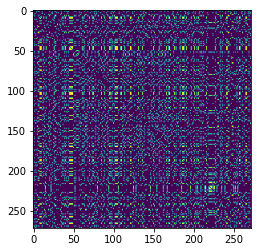

In [15]:
plt.imshow(adj_matrix)

In [16]:
ddf = data_df.groupby('Sub Region').mean()
cols = ddf.columns.tolist()[1:]
ddf = ddf[cols]
ddf = ddf.reset_index()
ddf.columns = ['DIVISION'] + ddf.columns.tolist()[1:]
ddf

DIVISION  ALL_fpll    ALL_tpll  SOCIAL_fpll  SOCIAL_tpll  \
0  East North Central  0.214168  313.720297     0.181626   242.562249   
1  East South Central  0.220635  291.150369     0.185679   240.344220   
2     Middle Atlantic  0.236278  294.225372     0.205707   226.358344   
3            Mountain  0.243551  302.664185     0.207375   241.952707   
4         New England  0.210300  310.265621     0.167689   278.520472   
5             Pacific  0.181117  332.553858     0.151782   257.295432   
6      South Atlantic  0.197367  307.404155     0.169912   249.197737   
7  West North Central  0.219237  318.343911     0.195506   241.690942   
8  West South Central  0.220033  313.625096     0.187058   260.068372   

   CARE_fpll   CARE_tpll  ALL_fpll_Local_I_Z_Score  ALL_fpll_Gi_Z_Score  \
0   0.058690   91.304485                 -0.180965             0.191547   
1   0.053020   81.611924                 -0.108450             0.559386   
2   0.064305   89.334212                  0.400219             1.719835   
3   0.048440  113.036425                  0.645136             1.984310   
4   0.056188   74.445838                 -0.192175            -0.098984   
5   0.034189   82.920253                  0.983302            -2.511622   
6   0.045753   71.918117                  0.242572            -1.783129   
7   0.063711   87.607437                 -0.116286             0.365960   
8   0.053974   70.223091                 -0.154033             0.650979   

   ALL_fpll_Local_I  ...  SOCIAL_tpll_Local_I  SOCIAL_tpll_GiD  \
0         -1.324238  ...            -0.453616         0.162402   
1         -0.577544  ...            -0.323300         0.078668   
2          1.854796  ...             0.563424         0.084175   
3          2.746893  ...            -0.879571         0.071996   
4         -0.729899  ...            -0.873148         0.053896   
5          5.181663  ...            -0.497345         0.118698   
6          1.544106  ...            -1.326050         0.222481   
7         -0.479471  ...            -0.180952         0.050343   
8         -0.976068  ...            -0.816679         0.127722   

   CARE_fpll_Local_I_Z_Score  CARE_fpll_Gi_Z_Score  CARE_fpll_Local_I  \
0                   0.001498              1.293732          -0.156572   
1                  -0.122601              0.159185          -0.635734   
2                   0.290091              1.670314           1.302585   
3                  -0.130672             -0.387213          -0.638405   
4                  -0.201537              0.415877          -0.754579   
5                   1.091624             -2.624444           5.697478   
6                   0.097512             -1.327959           0.480716   
7                   0.117921              1.163957           0.376994   
8                  -0.124971              0.347469          -0.806949   

   CARE_fpll_GiD  CARE_tpll_Local_I_Z_Score  CARE_tpll_Gi_Z_Score  \
0       0.188475                  -0.138176              0.811141   
1       0.083206                  -0.115407             -0.085334   
2       0.114769                  -0.055538              0.442854   
3       0.069084                   0.341591              1.848074   
4       0.052114                  -0.084505             -0.413595   
5       0.075504                  -0.104969             -0.001097   
6       0.195729                   0.056501             -1.276916   
7       0.063672                  -0.202797              0.236306   
8       0.127065                   0.079688             -1.027774   

   CARE_tpll_Local_I  CARE_tpll_GiD  
0          -1.042833       0.182865  
1          -0.604632       0.079876  
2          -0.360022       0.099393  
3           1.406218       0.100706  
4          -0.345084       0.043039  
5          -0.674762       0.114366  
6           0.186445       0.191891  
7          -0.790915       0.054574  
8           0.316309       0.103044  

[9 rows x 31 columns]

In [17]:
def shiftedColorMap(cmap, start=0.0, midpoint=0.5, stop=1, name='shiftedcmap'):
    import numpy as np
    import matplotlib
    import matplotlib.pyplot as plt
    from mpl_toolkits.axes_grid1 import AxesGrid
    '''
    Author of function: https://stackoverflow.com/users/1552748/paul-h
    Source webpage: https://stackoverflow.com/questions/7404116/defining-the-midpoint-of-a-colormap-in-matplotlib

    Function to offset the "center" of a colormap. Useful for
    data with a negative min and positive max and you want the
    middle of the colormap's dynamic range to be at zero.

    Input
    -----
      cmap : The matplotlib colormap to be altered
      start : Offset from lowest point in the colormap's range.
          Defaults to 0.0 (no lower offset). Should be between
          0.0 and `midpoint`.
      midpoint : The new center of the colormap. Defaults to 
          0.5 (no shift). Should be between 0.0 and 1.0. In
          general, this should be  1 - vmax / (vmax + abs(vmin))
          For example if your data range from -15.0 to +5.0 and
          you want the center of the colormap at 0.0, `midpoint`
          should be set to  1 - 5/(5 + 15)) or 0.75
      stop : Offset from highest point in the colormap's range.
          Defaults to 1.0 (no upper offset). Should be between
          `midpoint` and 1.0.
    '''
    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }

    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)

    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False), 
        np.linspace(midpoint, 1.0, 129, endpoint=True)
    ])

    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))

    newcmap = matplotlib.colors.LinearSegmentedColormap(name, cdict)
    plt.register_cmap(cmap=newcmap)

    return newcmap


In [18]:
def axes_position(string):
    if 'UNWEIGHTED' in f:
        y = 0
    elif 'ADJUSTED' in f:
        y = 2
    else:
        y = 1
    if 'Gi_Z' in f:
        x = 0
    else:
        x = 1
    return x,y

In [19]:
mi,ma = -2.5, 2.5
mid = 1 - (ma / (ma +abs(mi)))
new_cmap = shiftedColorMap(mpl.cm.RdYlGn, midpoint=mid, name='Custom_CMAP')

In [20]:
print(data_df['ALL_fpll_Gi_Z_Score'].min(),data_df['ALL_fpll_Gi_Z_Score'].max())

-2.7505190942422915 2.3231816270180925


In [21]:
# # Old version
# temp_features = ['AVG_NHFAMILY_IX_ADJUSTED_Gi_Z_Score',
#     'AVG_NHFAMILY_IX_ADJUSTED_Local_I_Z_Score', 
#     'AVG_NHFAMILY_TIME_ADJUSTED_Gi_Z_Score',
#     'AVG_NHFAMILY_TIME_ADJUSTED_Local_I_Z_Score',]


# titles = ['IX $z(G_i)$' ,
#           'IX $z(I_i)$',
#           't $z(G_i)$',
#           't $z(I_i)$',]

# division_gdf2 = dgdf.merge(ddf, on='DIVISION', how='left')
        

# pos = [[0,0],[0,1],[1,0],[1,1],[2,0],[2,1],[3,0],[3,1]]
# pos = [[0,0],[1,0],[0,1],[1,1],[0,2],[1,2],[0,3],[1,3]]

# fig, axes = plt.subplots(figsize=(8,6),sharex=True, sharey=True, ncols=2,nrows=2)
# for i in range(len(temp_features)):
#     f = temp_features[i]
#     y,x = pos[i]
#     mi,ma = division_gdf2[f].min(), division_gdf2[f].max()
#     mid = 1 - (ma / (ma +abs(mi)))
#     #new_cmap = shiftedColorMap(mpl.cm.RdYlGn, midpoint=mid, name='RdYlGn2')
#     division_gdf2.plot(ax=axes[x,y],column=f,legend=False, cmap='Custom_CMAP', vmin=-1, vmax=3)
#     states.boundary.plot(ax=axes[x,y],edgecolor='darkslategrey',linewidth=.5)
#     division_gdf2.boundary.plot(ax=axes[x,y],edgecolor='darkslategrey',linewidth=1.5)
#     axes[x,y].set_xlim((-126,-66))
#     axes[x,y].set_ylim((24,50))
#     #division_gdf2.plot(ax=axes[x,y],column=f,legend=False, cmap='RdYlGn', vmin=-2, vmax=2)
#     #division_gdf.plot(ax=axes[x,y],column=f,legend=False, cmap='inferno', vmin=-1, vmax=1)
#     axes[x,y].set_title(titles[i])
#     axes[x,y].axis('off')
#     #plt.title(f)

# im = plt.gca().get_children()[0]
# cax = fig.add_axes([1.05,0.1,0.03,0.8]) 
# bar = fig.colorbar(im, cax=cax, cmap='Custom_CMAP')
# for t in bar.ax.get_yticklabels():
#      t.set_fontsize(14)
# fig.tight_layout()
# plt.savefig(plots_dir+'DIVISION_MAP.png',dpi=600,bbox_inches = 'tight')
# plt.show()

In [22]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

(a) ALL_fpll_Gi_Z_Score
(b) ALL_fpll_Local_I_Z_Score
(c) ALL_tpll_Gi_Z_Score
(d) ALL_tpll_Local_I_Z_Score


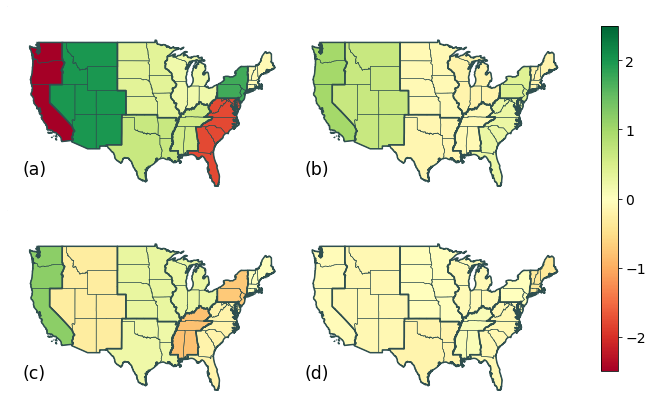

(a) CARE_fpll_Gi_Z_Score
(b) CARE_fpll_Local_I_Z_Score
(c) CARE_tpll_Gi_Z_Score
(d) CARE_tpll_Local_I_Z_Score


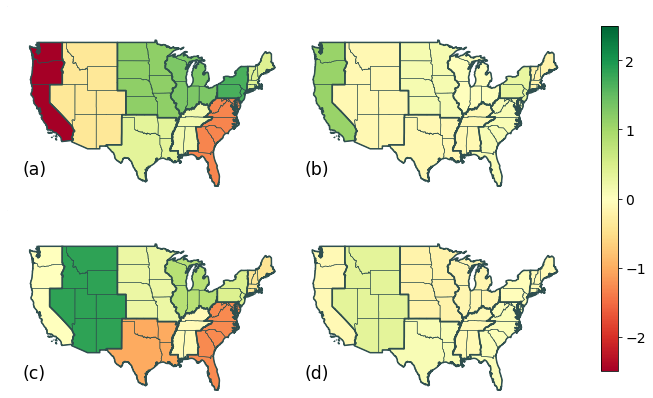

(a) SOCIAL_fpll_Gi_Z_Score
(b) SOCIAL_fpll_Local_I_Z_Score
(c) SOCIAL_tpll_Gi_Z_Score
(d) SOCIAL_tpll_Local_I_Z_Score


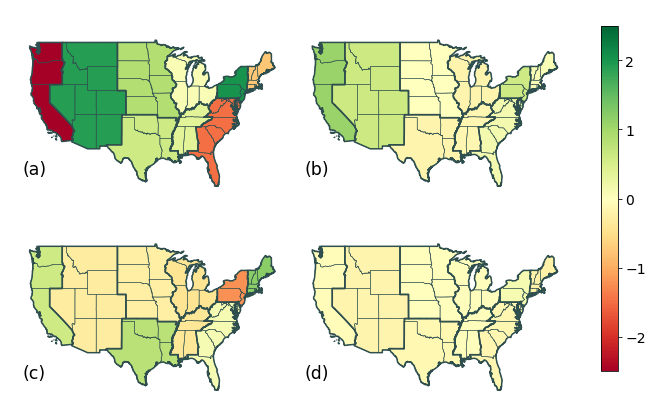

In [32]:
temp_features_wrapper = [
['ALL_fpll_Gi_Z_Score', 'ALL_fpll_Local_I_Z_Score','ALL_tpll_Gi_Z_Score','ALL_tpll_Local_I_Z_Score'],
['CARE_fpll_Gi_Z_Score','CARE_fpll_Local_I_Z_Score', 'CARE_tpll_Gi_Z_Score','CARE_tpll_Local_I_Z_Score'],
['SOCIAL_fpll_Gi_Z_Score','SOCIAL_fpll_Local_I_Z_Score','SOCIAL_tpll_Gi_Z_Score', 'SOCIAL_tpll_Local_I_Z_Score']]

image_labels = ['(a)','(b)','(c)','(d)']

output_name = ['ALL_F_T_', 'CARE_F_T_', 'SOCIAL_F_T_']
for j in range(len(temp_features_wrapper)):
    temp_features = temp_features_wrapper[j]

    # titles = ['IX $z(G_i)$' ,
    #         'IX $z(I_i)$',
    #         't $z(G_i)$',
    #         't $z(I_i)$',]
    titles = temp_features

    division_gdf2 = dgdf.merge(ddf, on='DIVISION', how='left')
    

    pos = [[0,0],[0,1],[1,0],[1,1],[2,0],[2,1],[3,0],[3,1]]
    pos = [[0,0],[1,0],[0,1],[1,1],[0,2],[1,2],[0,3],[1,3]]

    fig, axes = plt.subplots(figsize=(8,6),sharex=True, sharey=True, ncols=2,nrows=2)
    for i in range(len(temp_features)):
        f = temp_features[i]
        y,x = pos[i]
        mi,ma = division_gdf2[f].min(), division_gdf2[f].max()
        mid = 1 - (ma / (ma +abs(mi)))
        #new_cmap = shiftedColorMap(mpl.cm.RdYlGn, midpoint=mid, name='RdYlGn2')
        division_gdf2.plot(ax=axes[x,y],column=f,legend=False, cmap='Custom_CMAP', vmin=-2.5, vmax=2.5)
        states.boundary.plot(ax=axes[x,y],edgecolor='darkslategrey',linewidth=.5)
        division_gdf2.boundary.plot(ax=axes[x,y],edgecolor='darkslategrey',linewidth=1.5)

        axes[x,y].set_xlim((-130,-66))
        axes[x,y].set_ylim((25,55))

        #axes[x,y].set_xlim((-126,-66))
        #axes[x,y].set_ylim((24,50))

        #division_gdf2.plot(ax=axes[x,y],column=f,legend=False, cmap='RdYlGn', vmin=-2, vmax=2)
        #division_gdf.plot(ax=axes[x,y],column=f,legend=False, cmap='inferno', vmin=-1, vmax=1)
        #axes[x,y].set_title(titles[i])
        axes[x,y].axis('off')
        axes[x,y].text(0.1,0.1,image_labels[i], fontsize='xx-large', horizontalalignment='center', verticalalignment='center', transform=axes[x,y].transAxes)
        #plt.title(f)
        print(image_labels[i], temp_features[i])

    im = plt.gca().get_children()[0]
    cax = fig.add_axes([1.05,0.1,0.03,0.8]) 
    bar = fig.colorbar(im, cax=cax)
    for t in bar.ax.get_yticklabels():
        t.set_fontsize(14)
    plt.tight_layout()
    
    plt.savefig(plots_dir+output_name[j]+'DIVISION_MAP.png',dpi=600,bbox_inches = 'tight',transparent=False, facecolor='white')
    plt.show()

KeyError: 'AVG_NHFAMILY_IX_ADJUSTED_Gi_Z_Score'

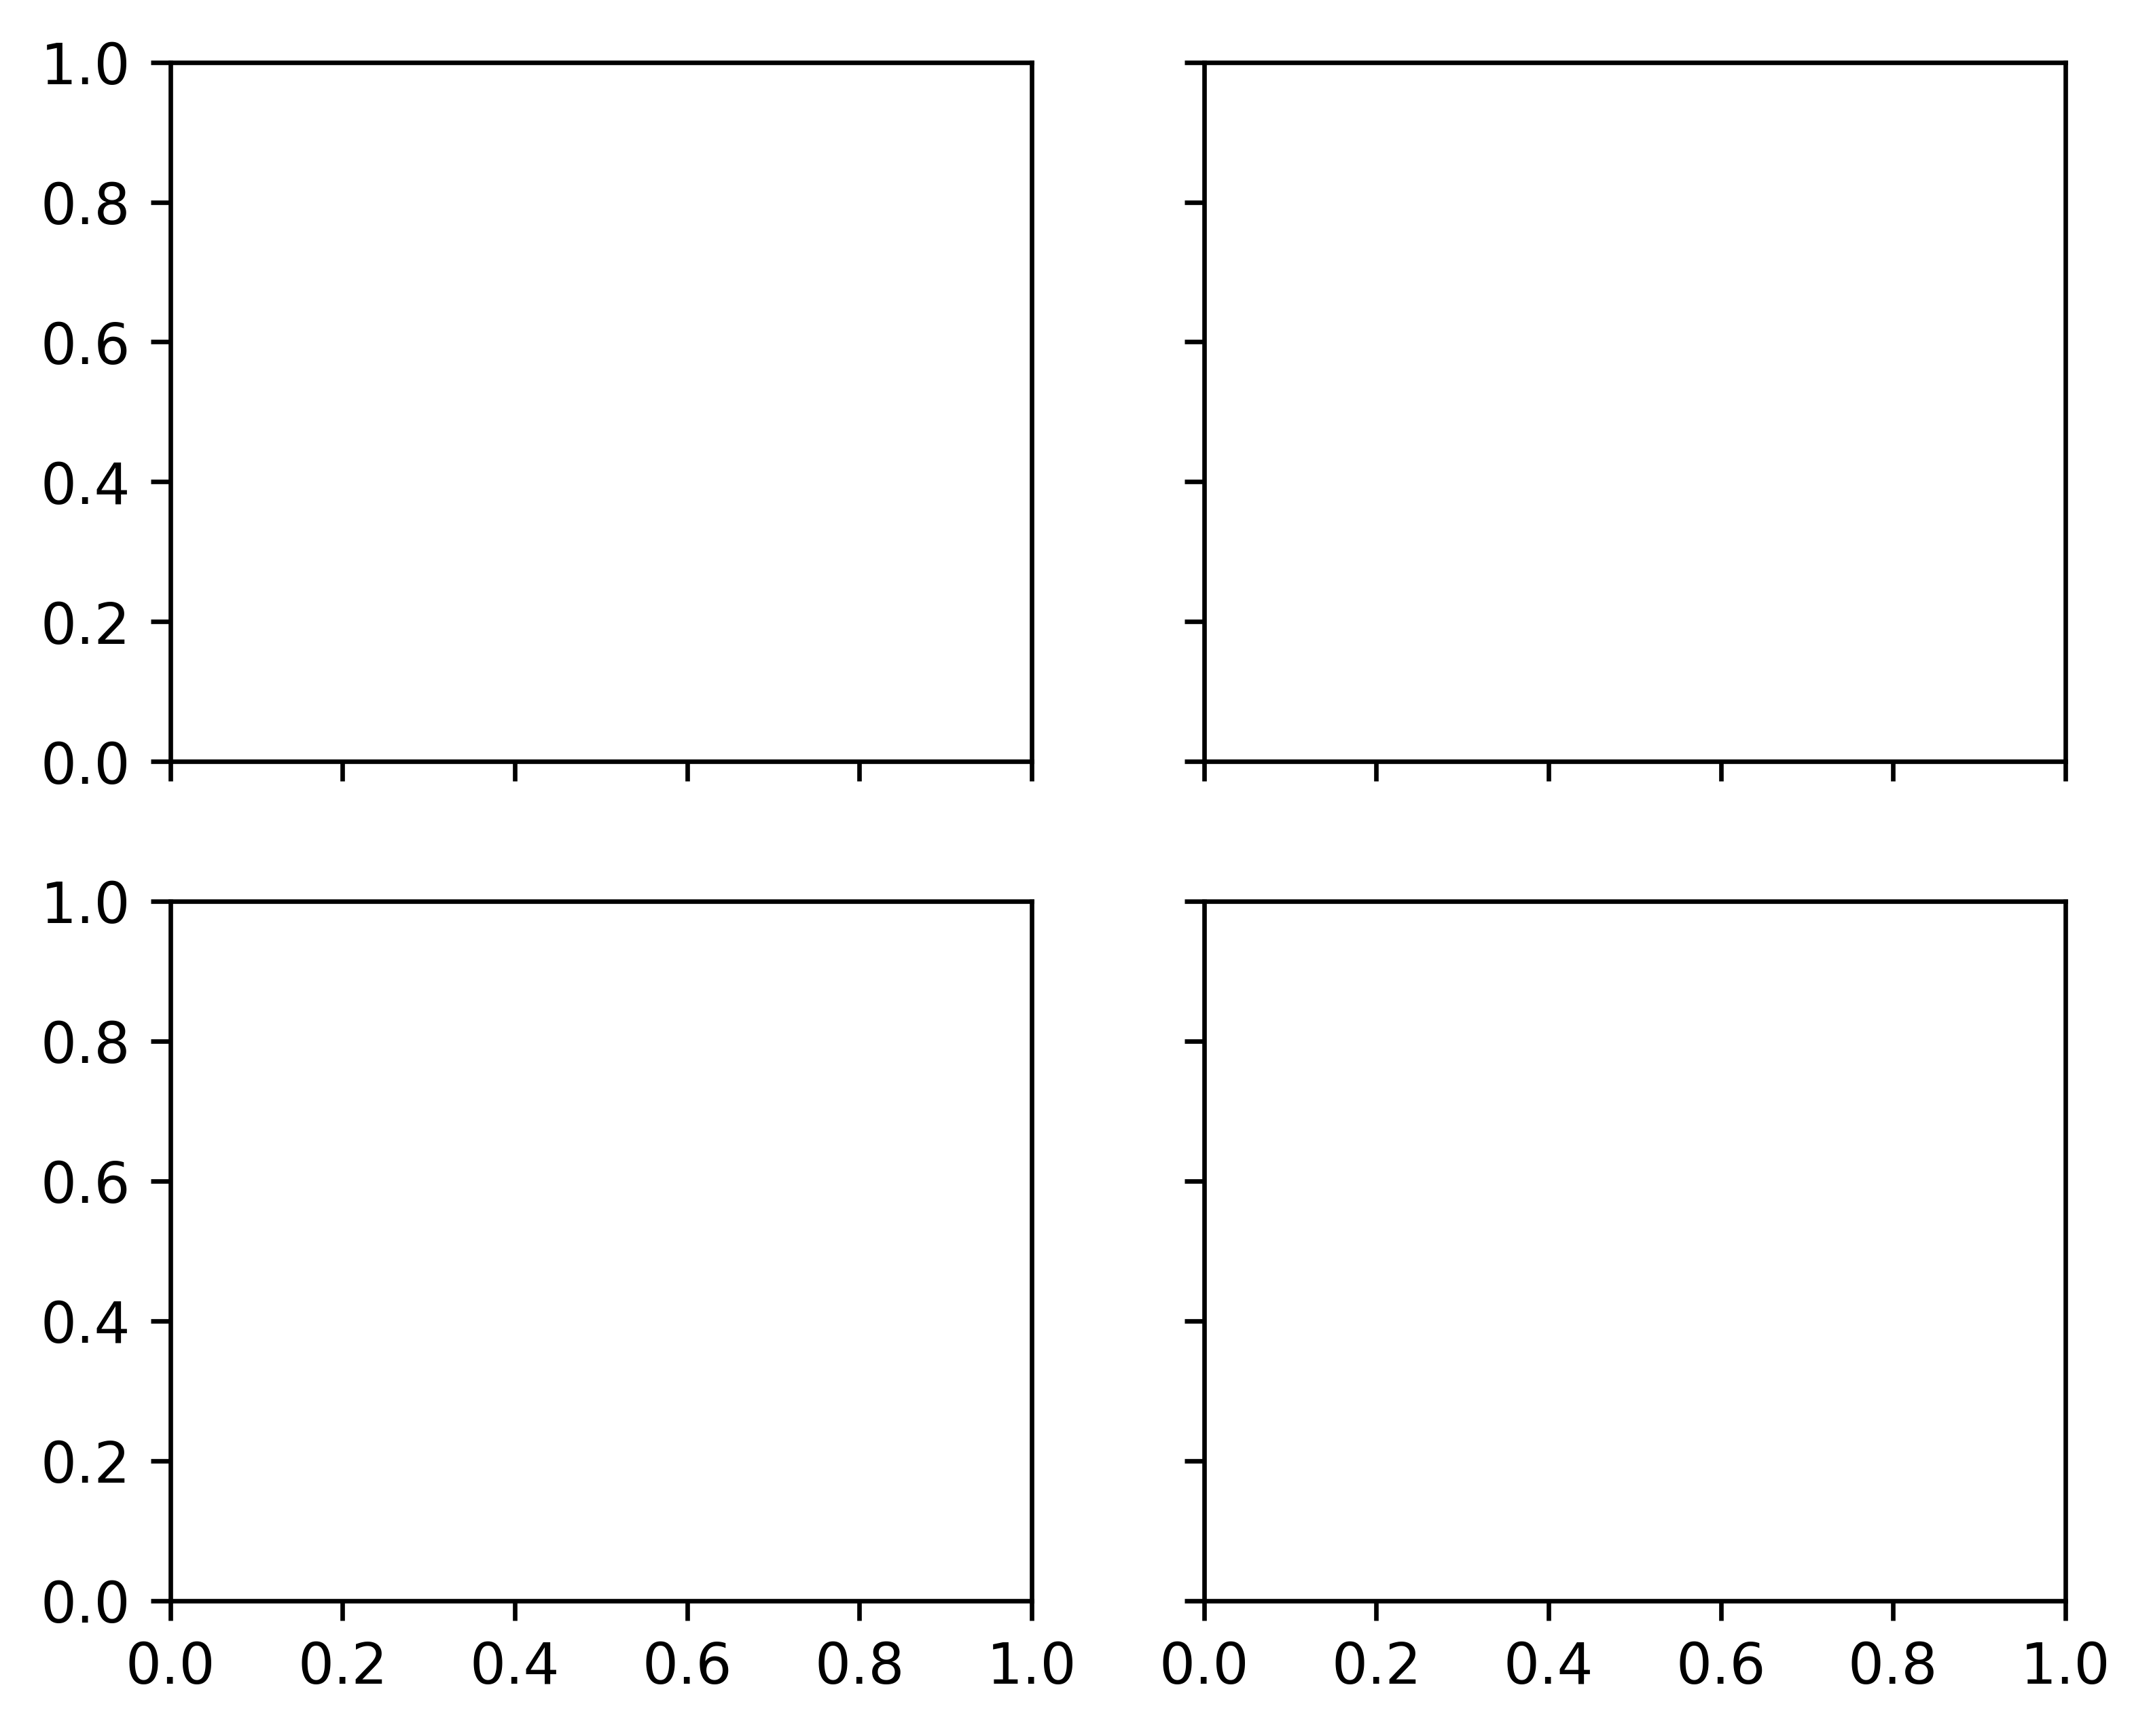

In [24]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
temp_features = ['AVG_NHFAMILY_IX_ADJUSTED_Gi_Z_Score',
    'AVG_NHFAMILY_IX_ADJUSTED_Local_I_Z_Score', 
    'AVG_NHFAMILY_TIME_ADJUSTED_Gi_Z_Score',
    'AVG_NHFAMILY_TIME_ADJUSTED_Local_I_Z_Score',]


titles = ['$Z_G(f)$' ,
          '$Z_I(f)$',
          '$Z_G(t_f)$',
          '$Z_I(t_f)$',]

division_gdf2 = dgdf.merge(ddf, on='DIVISION', how='left')

def colorbar(Mappable, Orientation='vertical', Extend='both'):
    Ax = Mappable.axes
    fig = Ax.figure
    divider = make_axes_locatable(Ax)
    Cax = divider.append_axes("right", size="5%", pad=0.05)
    return fig.colorbar(
        mappable=Mappable, 
        cax=Cax,
        use_gridspec=True, 
        extend=Extend,  # mostra um colorbar full resolution de z
        orientation=Orientation
    )

pos = [[0,0],[0,1],[1,0],[1,1],[2,0],[2,1],[3,0],[3,1]]
pos = [[0,0],[1,0],[0,1],[1,1],[0,2],[1,2],[0,3],[1,3]]

fig, axes = plt.subplots(figsize=(6,5),dpi=600, sharex=True, sharey=True, ncols=2,nrows=2)
for i in range(len(temp_features)):
    f = temp_features[i]
    y,x = pos[i]
    mi,ma = division_gdf2[f].min(), division_gdf2[f].max()
    mid = 1 - (ma / (ma +abs(mi)))
    new_cmap = shiftedColorMap(mpl.cm.RdYlGn, midpoint=mid, name='RdYlGnX'+str(i))
    im = division_gdf2.plot(ax=axes[x,y],column=f,legend=True, cmap='RdYlGnX'+str(i), legend_kwds={'orientation': "horizontal"})#, vmin=-1.5, vmax=1.5)
    #im = division_gdf2.plot(ax=axes[x,y],column=f,legend=True, cmap='RdYlGnX'+str(i), legend_kwds={'label': titles[i],  'orientation': "horizontal"})#, vmin=-1.5, vmax=1.5)
    states.boundary.plot(ax=axes[x,y],edgecolor='darkslategrey',linewidth=0.5)
    division_gdf2.boundary.plot(ax=axes[x,y],edgecolor='darkslategrey',linewidth=1.5)
    axes[x,y].set_xlim((-126,-66))
    axes[x,y].set_ylim((24,50))
    #division_gdf2.plot(ax=axes[x,y],column=f,legend=False, cmap='RdYlGn', vmin=-2, vmax=2)
    #division_gdf.plot(ax=axes[x,y],column=f,legend=False, cmap='inferno', vmin=-1, vmax=1)
    
    
    axes[x,y].set_title(titles[i])
    axes[x,y].axis('off')
    #plt.title(f)
    #colorbar(im)
#cb_ax = fig.axes[1] 
#cb_ax.tick_params(labelsize=200)
#plt.legend(fontsize=10)
fig.tight_layout()
plt.savefig(plots_dir+feature+'_division.png',dpi=600)
plt.show()

In [ ]:
plots_dir

# New Data Old Plots